# MNIST Digits Classification Experiments Tracking 
<b> Convolutional Neural Network (CNN) Model using PyTorch</b>

This notebook shows how you can use SageMaker Experiment Management Python SDK to organize, track, compare, and evaluate your machine learning (ML) model training experiments.

You can track artifacts for experiments, including data sets, algorithms, hyper-parameters, and metrics. Experiments executed on SageMaker such as SageMaker Autopilot jobs and training jobs will be automatically tracked. You can also track artifacts for additional steps within an ML workflow that come before/after model training e.g. data pre-processing or post-training model evaluation.

The APIs also let you search and browse your current and past experiments, compare experiments, and identify best performing models.

Now we will demonstrate these capabilities through an MNIST handwritten digits classification example. The experiment will be organized as follow:

1. Download and prepare the MNIST dataset.
2. Train a Convolutional Neural Network (CNN) Model. Tune the hyper parameter that configures the number of hidden channels in the model. Track the parameter configurations and resulting model accuracy using SageMaker Experiments Python SDK.
3. Finally use the search and analytics capabilities of Python SDK to search, compare and evaluate the performance of all model versions generated from model tuning in Step 2.
4. We will also see an example of tracing the complete linage of a model version i.e. the collection of all the data pre-processing and training configurations and inputs that went into creating that model version.

## Setup

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install sagemaker-experiments

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
from torchvision import datasets, transforms

%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import boto3
import time

from sagemaker.analytics import ExperimentAnalytics
from sagemaker import get_execution_role
from sagemaker.session import Session
import sagemaker

from smexperiments.trial_component import TrialComponent
from smexperiments.experiment import Experiment
from smexperiments.tracker import Tracker
from smexperiments.trial import Trial

In [4]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()

## Load & Prep Data

### Create S3 Bucket to hold Data

In [5]:
# create a s3 bucket to hold data, note that your account might have already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
prefix = 'mnist'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

### Download Dataset

In [6]:
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=False)

In [7]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [8]:
test_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [9]:
train_set.data[2]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,  67, 232,  39,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  62,  81,   0,   

In [10]:
train_set.data[2].shape

torch.Size([28, 28])

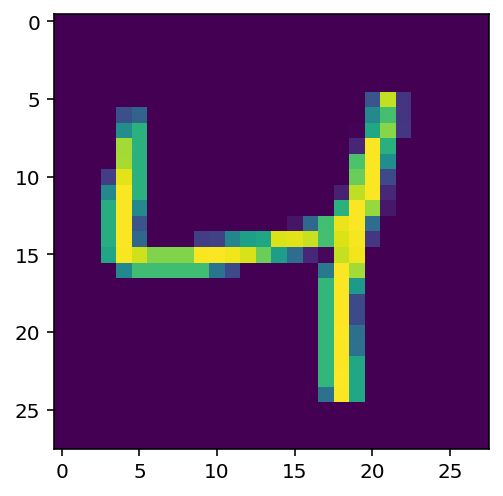

In [11]:
plt.imshow(train_set.data[2].numpy())

After transforming the images in the dataset, we upload it to s3.

In [12]:
inputs = sagemaker.Session().upload_data(path='mnist', bucket=bucket, key_prefix=prefix)
print('Input Location: {}'.format(inputs))

Input Location: s3://sagemaker-experiments-us-east-1-892313895307/mnist


## Setup & Track Data Science Experiments

### Create a Pre-processing Tracker (optional)

In [13]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

### Create an Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

In [14]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}", 
    description="Classification of mnist hand-written digits", 
    sagemaker_boto_client=sm)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f837c0a0390>,experiment_name='mnist-hand-written-digits-classification-1598456787',description='Classification of mnist hand-written digits',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:892313895307:experiment/mnist-hand-written-digits-classification-1598456787',response_metadata={'RequestId': '40d6a8b4-0981-4cef-ad6b-310784b9a83b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '40d6a8b4-0981-4cef-ad6b-310784b9a83b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Wed, 26 Aug 2020 15:46:27 GMT'}, 'RetryAttempts': 0})


### Track Experiment

<b>Now create a Trial for each training run to track the it's inputs, parameters, and metrics.</b><br><br>
While training the CNN model on SageMaker, we will experiment with several values for the number of hidden channel in the model. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

Note the execution of the following code takes a while.

In [15]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [16]:
hidden_channel_trial_name_map = {}

If you want to run the following training jobs asynchronously, you may need to increase your resource limit. Otherwise, you can run them sequentially.

In [17]:
preprocessing_trial_component = tracker.trial_component

In [18]:
for i, num_hidden_channel in enumerate([2, 5, 10]):
    # create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        entry_point='./mnist.py',
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c5.xlarge',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'kernel_size': 5,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ],
        enable_sagemaker_metrics=True # IMPORTANT
    )
    
    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))
    
    # now associate the estimator with an Experiment and a Trial
    estimator.fit(
        inputs={'training': inputs}, 
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True, 
    )
    
    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:sagemaker:Creating training-job with name: cnn-training-job-1598457192


2020-08-26 15:53:12 Starting - Starting the training job...
2020-08-26 15:53:14 Starting - Launching requested ML instances.........
2020-08-26 15:54:54 Starting - Preparing the instances for training...
2020-08-26 15:55:35 Downloading - Downloading input data......
2020-08-26 15:56:41 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-26 15:56:56,646 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-26 15:56:56,648 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-26 15:56:56,657 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-26 15:56:59,709 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-26 15:57:00,010 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2020-08-26 15:57:


2020-08-26 15:57:44 Uploading - Uploading generated training model
2020-08-26 15:57:44 Completed - Training job completed
Test Average loss: 0.1152, Test Accuracy: 97%;

Saving the model.
2020-08-26 15:57:34,670 sagemaker-containers INFO     Reporting training SUCCESS
Training seconds: 129
Billable seconds: 129


INFO:sagemaker:Creating training-job with name: cnn-training-job-1598457480


2020-08-26 15:58:01 Starting - Starting the training job...
2020-08-26 15:58:03 Starting - Launching requested ML instances.........
2020-08-26 15:59:43 Starting - Preparing the instances for training.........
2020-08-26 16:01:27 Downloading - Downloading input data
2020-08-26 16:01:27 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-26 16:01:28,709 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-26 16:01:28,712 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-26 16:01:28,721 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-26 16:01:31,743 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-26 16:01:32,244 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating s

2020-08-26 16:02:07,814 sagemaker-containers INFO     Reporting training SUCCESS

2020-08-26 16:02:18 Uploading - Uploading generated training model
2020-08-26 16:02:18 Completed - Training job completed
Training seconds: 73
Billable seconds: 73


INFO:sagemaker:Creating training-job with name: cnn-training-job-1598457767


2020-08-26 16:02:47 Starting - Starting the training job...
2020-08-26 16:02:49 Starting - Launching requested ML instances.........
2020-08-26 16:04:30 Starting - Preparing the instances for training...
2020-08-26 16:05:15 Downloading - Downloading input data......
2020-08-26 16:06:12 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-26 16:06:27,832 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-26 16:06:27,834 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-26 16:06:27,844 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-26 16:06:30,886 sagemaker_pytorch_container.training INFO     Invoking user training script.

2020-08-26 16:06:27 Training - Training image download completed. Training in progress.2020-08-26 16:07:31,753 sagemaker-containers I


2020-08-26 16:08:15 Uploading - Uploading generated training modelTest Average loss: 0.1072, Test Accuracy: 97%;

Saving the model.
2020-08-26 16:08:09,599 sagemaker-containers INFO     Reporting training SUCCESS

2020-08-26 16:08:22 Completed - Training job completed
Training seconds: 187
Billable seconds: 187


## Compare Trials

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

In [25]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [26]:
trial_component_analytics = ExperimentAnalytics(
                                sagemaker_session=Session(sess, sm), 
                                experiment_name=mnist_experiment.experiment_name,
                                search_expression=search_expression,
                                sort_by="metrics.test:accuracy.max",
                                sort_order="Descending",
                                metric_names=['test:accuracy'],
                                parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
                            )

In [27]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count,training - MediaType,training - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value
0,cnn-training-job-1598457480-aws-training-job,Training,arn:aws:sagemaker:us-east-1:892313895307:train...,0.2,2.0,5.0,"""sgd""",94.0,97.0,95.5,2.121320,97.0,2,None,s3://sagemaker-experiments-us-east-1-892313895...,None,s3://sagemaker-us-east-1-892313895307/,None,s3://sagemaker-us-east-1-892313895307/cnn-trai...
1,cnn-training-job-1598457192-aws-training-job,Training,arn:aws:sagemaker:us-east-1:892313895307:train...,0.2,2.0,2.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2,None,s3://sagemaker-experiments-us-east-1-892313895...,None,s3://sagemaker-us-east-1-892313895307/,None,s3://sagemaker-us-east-1-892313895307/cnn-trai...
2,cnn-training-job-1598457767-aws-training-job,Training,arn:aws:sagemaker:us-east-1:892313895307:train...,0.2,2.0,10.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2,None,s3://sagemaker-experiments-us-east-1-892313895...,None,s3://sagemaker-us-east-1-892313895307/,None,s3://sagemaker-us-east-1-892313895307/cnn-trai...


## Track Model Lineage 

To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [28]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": hidden_channel_trial_name_map[2]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [29]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,mnist-dataset - MediaType,mnist-dataset - Value,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,...,train:loss - Avg,train:loss - StdDev,train:loss - Last,train:loss - Count,training - MediaType,training - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value
0,TrialComponent-2020-08-26-154622-jhdn,Preprocessing,0.1307,0.3081,s3/uri,s3://sagemaker-experiments-us-east-1-892313895...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn-training-job-1598457192-aws-training-job,Training,NaN,NaN,NaN,NaN,arn:aws:sagemaker:us-east-1:892313895307:train...,520713654638.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.c5.xlarge,...,0.456435,0.352582,0.157364,18.0,NaN,s3://sagemaker-experiments-us-east-1-892313895...,NaN,s3://sagemaker-us-east-1-892313895307/,NaN,s3://sagemaker-us-east-1-892313895307/cnn-trai...


## Deploy Best Model

Now we'll take the best (as sorted) and create an endpoint for it.

In [30]:
# first model is best since sorted by accuracy at the analytics step above 
best_trial_component_name = trial_component_analytics.dataframe().iloc[0]['TrialComponentName']
best_trial_component = TrialComponent.load(best_trial_component_name)

model_data = best_trial_component.output_artifacts['SageMaker.ModelArtifact'].value
env = {'hidden_channels': str(int(best_trial_component.parameters['hidden_channels'])), 
       'dropout': str(best_trial_component.parameters['dropout']), 
       'kernel_size': str(int(best_trial_component.parameters['kernel_size']))}

In [31]:
model_data

's3://sagemaker-us-east-1-892313895307/cnn-training-job-1598457480/output/model.tar.gz'

In [32]:
env

{'hidden_channels': '5', 'dropout': '0.2', 'kernel_size': '5'}

In [33]:
model = PyTorchModel(
            model_data, 
            role, 
            './mnist.py', 
            env=env, 
            sagemaker_session=sagemaker.Session(sagemaker_client=sm),
            framework_version='1.1.0',
            name=best_trial_component.trial_component_name)

In [34]:
model.__dict__

{'model_data': 's3://sagemaker-us-east-1-892313895307/cnn-training-job-1598457480/output/model.tar.gz',
 'image': None,
 'role': 'arn:aws:iam::892313895307:role/service-role/AmazonSageMaker-ExecutionRole-20200609T132696',
 'predictor_cls': sagemaker.pytorch.model.PyTorchPredictor,
 'env': {'hidden_channels': '5', 'dropout': '0.2', 'kernel_size': '5'},
 'name': 'cnn-training-job-1598457480-aws-training-job',
 'vpc_config': None,
 'sagemaker_session': <sagemaker.session.Session at 0x7f8376338860>,
 '_model_name': None,
 'endpoint_name': None,
 '_is_compiled_model': False,
 '_enable_network_isolation': False,
 'model_kms_key': None,
 'entry_point': './mnist.py',
 'source_dir': None,
 'dependencies': [],
 'git_config': None,
 'enable_cloudwatch_metrics': False,
 'container_log_level': 20,
 'bucket': None,
 'key_prefix': None,
 'uploaded_code': None,
 'repacked_model_data': None,
 'py_version': 'py3',
 'framework_version': '1.1.0',
 'model_server_workers': None}

In [35]:
predictor = model.deploy(
    instance_type='ml.m5.xlarge',
    initial_instance_count=1)

INFO:sagemaker:Creating model with name: cnn-training-job-1598457480-aws-training-job
INFO:sagemaker:Creating endpoint with name cnn-training-job-1598457480-aws-training-job


---------------!

In [36]:
predictor.__dict__

{'endpoint': 'cnn-training-job-1598457480-aws-training-job',
 'sagemaker_session': <sagemaker.session.Session at 0x7f8376338860>,
 'serializer': <sagemaker.predictor._NPYSerializer at 0x7f837c634eb8>,
 'deserializer': <sagemaker.predictor._NumpyDeserializer at 0x7f837c634cf8>,
 'content_type': 'application/x-npy',
 'accept': 'application/x-npy',
 '_endpoint_config_name': 'cnn-training-job-1598457480-aws-training-job',
 '_model_names': <map at 0x7f83767e5cf8>}